# NASA Space Apps Challenge
## Team Operation: Proetheus
<table>
    <tr>
        <td><img src="http://www.kepfeltoltes.eu/images/2020/10/04/711output_onlinepngtools.png"></img> </td>
        <td><img src="https://miro.medium.com/max/350/1*Yf66eLjU4H3g7pIvpXlM5w.jpeg"></img> </td>
    </tr>
</table>


### How to use this notebook:

#### Install docker
<code>
sudo apt-get update
sudo apt-get install apt-transport-https ca-certificates curl gnupg-agent software-properties-common
</code>

#### Get the official  tensorflow docker image
<code>docker pull tensorflow/tensorflow</code>

#### Run docker image
<code>docker run -it --rm tensorflow/tensorflow bash</code>

In [ ]:
# Install necessary libraries
!pip install pandas
!pip install pymongo
!pip install sklearn

In [3]:
import pandas as pd
import pymongo
import tensorflow as tf
import tensorflow.keras as keras
from datetime import datetime as dt
import sklearn

# Export and format data

In [4]:
# Pymongo Connection
client = pymongo.MongoClient(host="34.123.34.16", username="root", password="*******")
# Set db name
db = client.hackathon

# Export data from Database
data = pd.DataFrame(list(db.relevant_points2.find()))

# Conat weather data
data = pd.concat(
    [
        data,
        pd.DataFrame.from_records(data.weather.apply(lambda row: row[0])),
    ], 
    axis=1
)

# Concat onehot encoded column
data = pd.concat(
    [
        data,
        pd.get_dummies(data.main),
    ], 
    axis=1
)

# Drop columns
data.drop(
    columns=[
        "_id", "id", "latitude", "longitude", "dt", "date",
        "weather", "description", "icon", "main", "external_id"], 
    inplace=True
)


In [5]:
def fillna(df:pd.DataFrame):
    for col in df.columns:
        df.loc[df[col].isna(), col] = df[col].mean() 
        if any(df[col].isnull()):
            print(col)
        
    return df

# Create Deep Learning Model

In [6]:
# Get train and test data
from sklearn.model_selection import train_test_split
target = data.confidence
raw = data.drop(columns=["confidence"])
raw = fillna(raw)

x_train, x_test, y_train, y_test = train_test_split(raw, target, test_size=0.33, )


In [8]:
# Get data sahpe for feed the training
input_shape = len(x_train.columns)

In [9]:
# Create model
model = keras.Sequential()
model.add(keras.Input(input_shape))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(500, activation='relu'))
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(40, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1, activation='relu', kernel_initializer='normal'))


In [10]:
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc', "msle"])

In [11]:
# Fit the model
model.fit(x_train,y_train, epochs=200, batch_size=100)

Epoch 1/20
1170/1170 [==============================] - 3s 2ms/step - loss: 0.0326 - acc: 0.6106 - msle: 0.0201
Epoch 2/20
1170/1170 [==============================] - 3s 2ms/step - loss: 0.0295 - acc: 0.6106 - msle: 0.0182
Epoch 3/20
1170/1170 [==============================] - 3s 2ms/step - loss: 0.0282 - acc: 0.6108 - msle: 0.0174
Epoch 4/20
1170/1170 [==============================] - 3s 2ms/step - loss: 0.0274 - acc: 0.6108 - msle: 0.0169
Epoch 5/20
1170/1170 [==============================] - 3s 2ms/step - loss: 0.0268 - acc: 0.6109 - msle: 0.0165
Epoch 6/20
1170/1170 [==============================] - 3s 2ms/step - loss: 0.0262 - acc: 0.6109 - msle: 0.0161
Epoch 7/20
1170/1170 [==============================] - 3s 2ms/step - loss: 0.0257 - acc: 0.6110 - msle: 0.0158
Epoch 8/20
1170/1170 [==============================] - 3s 2ms/step - loss: 0.0254 - acc: 0.6109 - msle: 0.0156
Epoch 9/20
1170/1170 [==============================] - 3s 3ms/step - loss: 0.0249 - acc: 0.6109 - msle:

In [12]:
# evaluate the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 61.37%


In [ ]:
# Save model to disk
model.save(f"model_run_{dt.now()}.h5")

# Prediction Analisys

<AxesSubplot:>

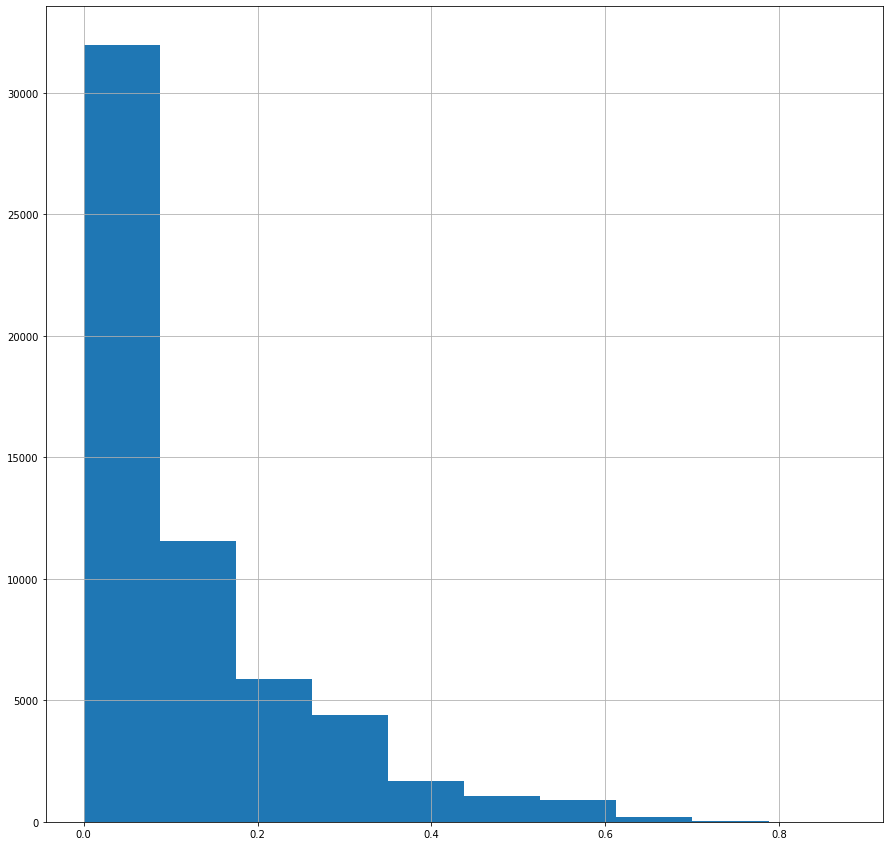

In [49]:
# Check predicted values on test set
predictions = model.predict(x_test)
pd.DataFrame(predictions)[0].hist(figsize=(15,15))

<AxesSubplot:>

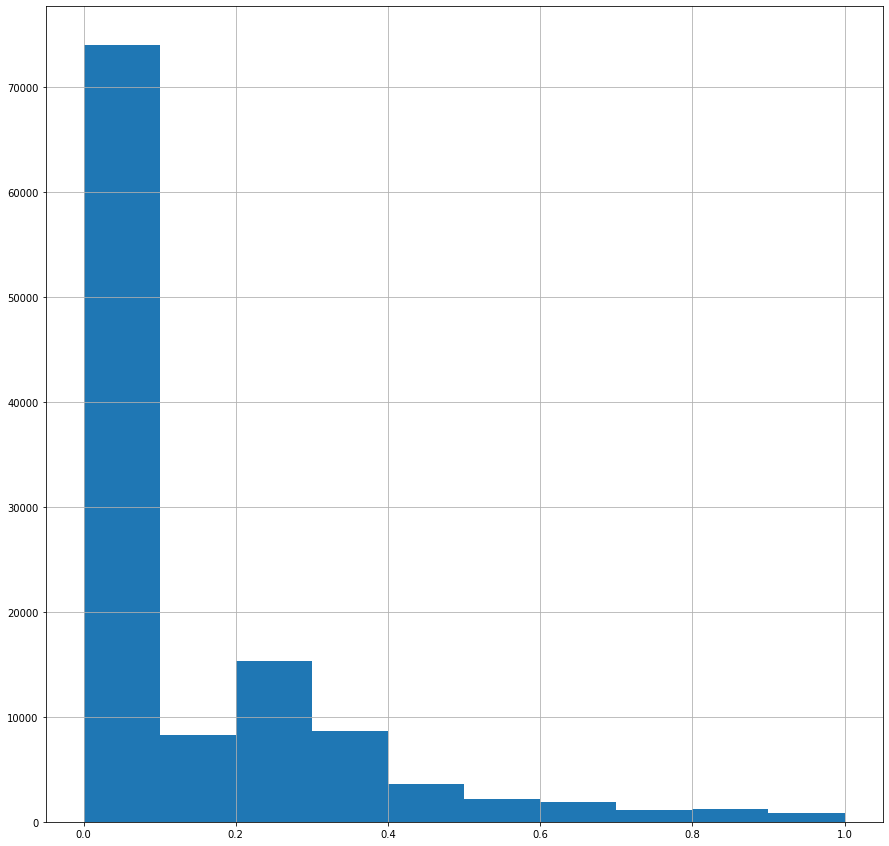

In [48]:
# Real tarin labels
y_train.hist(figsize=(15,15))

array([[<AxesSubplot:title={'center':'a'}>]], dtype=object)

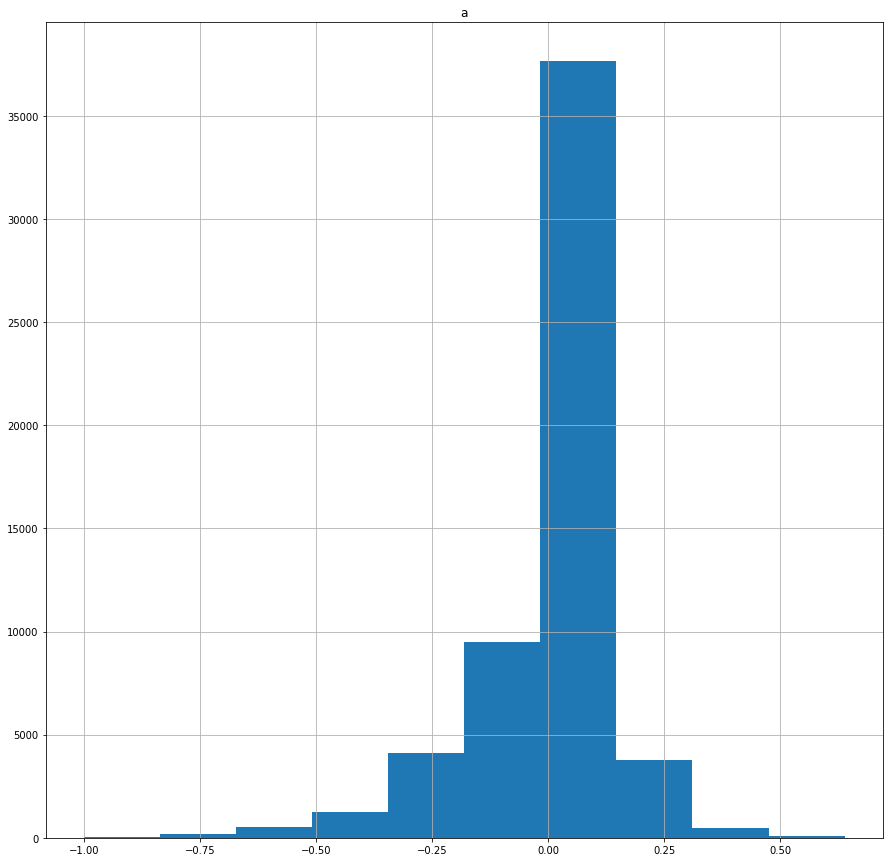

In [47]:
# Check predicted value distance
bsd = []
for i in range(predictions.shape[0]):
    bsd.append(predictions[i][0] - y_test.iloc[i])
 
pd.DataFrame({'a': bsd}).hist(figsize=(15,15))

<AxesSubplot:xlabel='idx'>

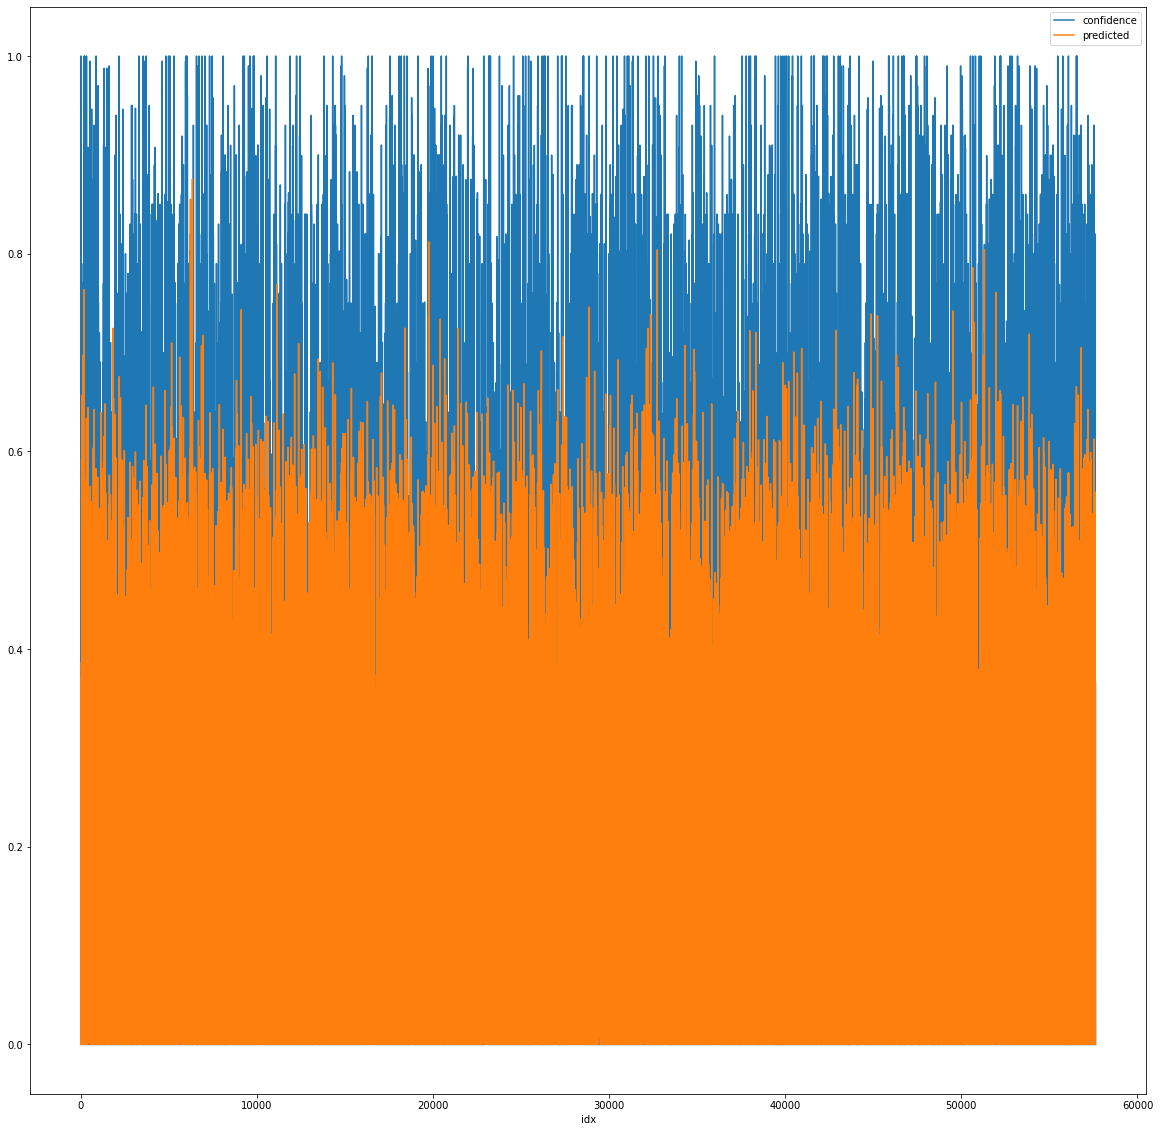

In [46]:
# Plot prediction vs real value on test data 
from matplotlib.pyplot import plot

predictions_all = pd.concat(
    [x_test.reset_index(drop=True), 
     y_test.reset_index(drop=True), 
     pd.DataFrame(predictions, columns=["predicted"])], axis=1)

predictions_all["idx"] = predictions_all.index

predictions_all.plot("idx", ["confidence", "predicted"], figsize=(20,20))

### Conclusion
As you can see because of the mainly negative samples (There are less exaples of active fire than no fire) the regression mode allways predict lower values to optimise the mse vale. 

__Possible solutions:__
- Oversample the fire data
- Generate virtual fires based on active fire data
- Ramp up period before fire start on target values
- More Active fire data
- More factors (this 19 which we scraped from open databases is not enough)

In [55]:
from sklearn.metrics import *

print("mae: ", mean_absolute_error(y_test, predictions))
print("mse: ", mean_squared_error(y_test, predictions))
print("r2 score: ", r2_score(y_test, predictions))


mae:  0.09561049760334289
mse:  0.021814178642924023
r2 score:  0.45436368761730084
